In [1]:
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score
from hyperbolicity.utils import construct_weighted_matrix
from hyperbolicity.tree_fitting_methods.gromov import gromov_tree
import numpy as np
import torch
from scGeneFit.functions import *
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix
import pickle

In [2]:
with open('/share/home/houedry/projects/DifferentiableHyperbolicity/hyperbolicity/datasets/D_zeisel.pkl', 'rb') as f:
    distances = pickle.load(f)

[X, Y, names]= load_example_data("zeisel")
N,d=X.shape
print(X.shape, Y.shape)
Y=Y-1 # to start from 0

print('nb classes level 0:',len(np.unique(Y[0])))
print('nb classes level 1:',len(np.unique(Y[1])))

(3005, 4000) (2, 3005)
nb classes level 0: 7
nb classes level 1: 48


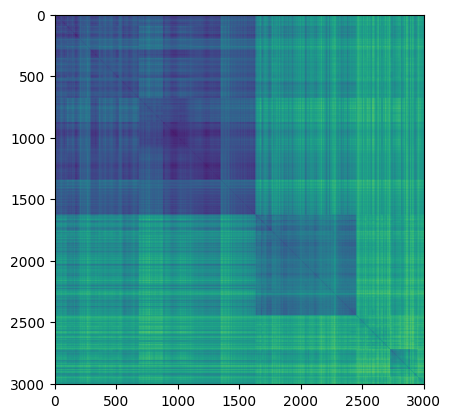

In [3]:
import torch
import pickle
import torch.nn.functional as F

def cosine_distance_matrix(X):
    X_normalized = F.normalize(X, p=2, dim=1)
    cosine_similarity = torch.mm(X_normalized, X_normalized.t())
    return 1 - cosine_similarity


X_torch = torch.from_numpy(X)
distance = cosine_distance_matrix(X_torch)
distance = distance.fill_diagonal_(0)

plt.imshow(distance)

In [5]:
data = torch.load('/share/home/houedry/projects/DifferentiableHyperbolicity/hyperbolicity/expes/launch_files/results_expes/D_zeisel_2025-05-07_14-49-13/lr_0.001_dr_1.0_sd_1.0_epoch_2000_batch_32_n_batches_100.pt')
best_weights = data['weights']
num_nodes = distances.shape[0]
edges = torch.triu_indices(num_nodes, num_nodes, offset=1)
distance_optimized = construct_weighted_matrix(best_weights, num_nodes, edges)

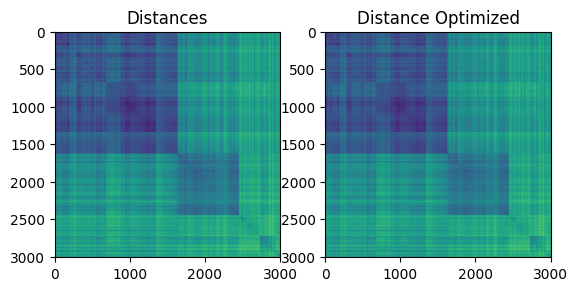

In [6]:
plt.subplot(1, 2, 1)
plt.title("Distances")
plt.imshow(distances)

plt.subplot(1, 2, 2)
plt.title("Distance Optimized")
plt.imshow(distance_optimized)
plt.show()

In [8]:
""" new_row = torch.full((1, distance_optimized.shape[1]), 20)
distance_optimized_node = torch.cat((distance_optimized, new_row), dim=0)
new_column = torch.full((distance_optimized_node.shape[0], 1), 20)
distance_optimized_node = torch.cat((distance_optimized_node, new_column), dim=1)
distance_optimized_node[-1,-1] = 0 """

' new_row = torch.full((1, distance_optimized.shape[1]), 20)\ndistance_optimized_node = torch.cat((distance_optimized, new_row), dim=0)\nnew_column = torch.full((distance_optimized_node.shape[0], 1), 20)\ndistance_optimized_node = torch.cat((distance_optimized_node, new_column), dim=1)\ndistance_optimized_node[-1,-1] = 0 '

In [9]:
tree = gromov_tree(distance_optimized.numpy(), num_nodes-1)

In [10]:
tree_distance = tree[:-1, :-1]

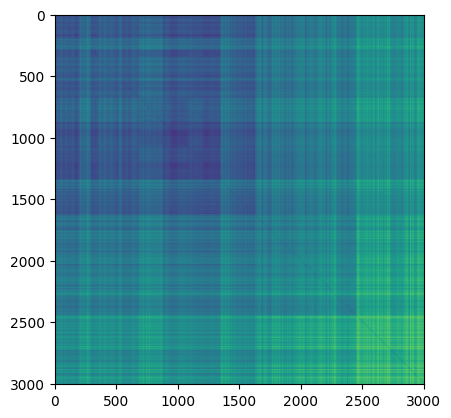

In [11]:
plt.imshow(tree_distance)

In [12]:
def clustering_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-cm) 
    return cm[row_ind, col_ind].sum() / np.sum(cm)

In [6]:
clustering = AgglomerativeClustering(n_clusters=7, metric='precomputed', linkage='complete').fit(distance)
labels = clustering.labels_
ari_base = adjusted_rand_score(Y[0], clustering.labels_)
print('Adjusted Rank Index no optimization', ari_base)

Adjusted Rank Index no optimization 0.4419610502105303


In [30]:
from scipy.spatial.distance import squareform
condensed = squareform(distance)  
Z = linkage(condensed, method='complete')  # same linkage method as scikit-learn
labels = fcluster(Z, t=7, criterion='maxclust')  # same number of cluste
ari_base = adjusted_rand_score(Y[0], labels)
print('Adjusted Rank Index no optimization', ari_base)

Adjusted Rank Index no optimization 0.4419610502105303


In [22]:
import os
import pandas as pd
import torch
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, silhouette_score

# Directory with .pt files
pt_dir = '/share/home/houedry/projects/DifferentiableHyperbolicity/hyperbolicity/expes/results_expes/D_zeisel_2025-05-07_14-49-13/'
pt_files = [f for f in os.listdir(pt_dir) if f.endswith('.pt')]

results = []

for pt_file in pt_files:
    parts = pt_file.split('_')
    lr = float(parts[1])
    dr = float(parts[3])
    sd = float(parts[5])
    
    data = torch.load(os.path.join(pt_dir, pt_file))
    best_weights = data['weights']
    
    num_nodes = distances.shape[0]
    edges = torch.triu_indices(num_nodes, num_nodes, offset=1)
    distance_optimized = construct_weighted_matrix(best_weights, num_nodes, edges)
    
    clustering = AgglomerativeClustering(n_clusters=7, metric='precomputed', linkage='complete').fit(distance_optimized)
    labels = clustering.labels_
    
    silhouette = silhouette_score(distance_optimized, labels, metric='precomputed')
    ari = adjusted_rand_score(Y[0], labels)
    
    results.append({
        'ARI': ari,
        'silhouette': silhouette,
        'learning_rate': lr,
        'distance_reg': dr,
        'scale_delta': sd
    })

# Save all results at once
output_csv_path = '/share/home/houedry/projects/DifferentiableHyperbolicity/hyperbolicity/expes/results_expes/results_simple_summary.csv'
results_df = pd.DataFrame(results)
results_df.to_csv(output_csv_path, index=False)


In [27]:
results_df.loc[results_df['ARI'].idxmax()]

ARI              0.490734
silhouette       0.303774
learning_rate    0.001000
distance_reg     0.010000
scale_delta      0.100000
Name: 36, dtype: float64

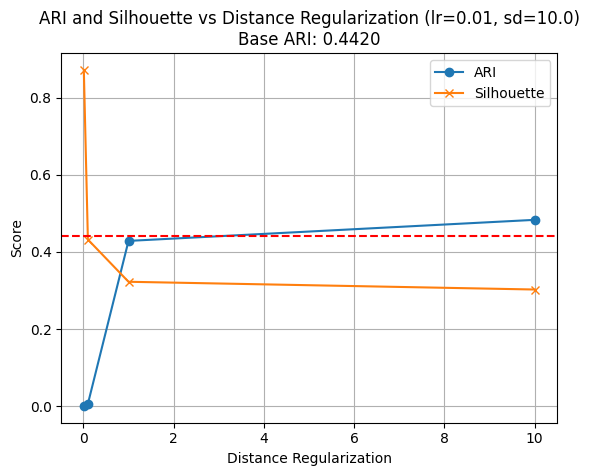

In [58]:
fixed_lr = 0.01  # Replace with the desired learning_rate
fixed_sd = 10.0  # Replace with the desired scale_delta

filtered_df = results_df[(results_df['learning_rate'] == fixed_lr) & (results_df['scale_delta'] == fixed_sd)]
filtered_df = filtered_df.sort_values(by='distance_reg')

plt.plot(filtered_df['distance_reg'], filtered_df['ARI'], label='ARI', marker='o')
plt.plot(filtered_df['distance_reg'], filtered_df['silhouette'], label='Silhouette', marker='x')
plt.xlabel('Distance Regularization')
plt.ylabel('Score')
plt.title(f'ARI and Silhouette vs Distance Regularization (lr={fixed_lr}, sd={fixed_sd})\nBase ARI: {ari_base:.4f}')
plt.legend()
plt.grid(True)
plt.axhline(y=ari_base, color='r', linestyle='--', label='Base ARI')
plt.show()

In [55]:
df2 = pd.read_csv('/share/home/houedry/projects/DifferentiableHyperbolicity/hyperbolicity/expes/launch_files/results_expes/D_cbmc_2025-05-09_17-07-53/results.csv')

In [57]:
# Strip any whitespace from column names
df2.columns = df2.columns.str.strip()

# Find the row with the minimum value in 'mean_optim_l1'
df2.loc[df2['mean_optim_l1'].idxmin()]

learning_rate                 0.010000
distance_reg                  1.000000
scale_delta                  10.000000
epochs                     1000.000000
batch_size                   32.000000
n_batches                   100.000000
intermediate_distortion       0.269859
intermediate_l1               0.008512
mean_optim_l1                 0.092338
min_optim_l1                  0.073710
std_optim_l1                  0.014559
mean_optim_distortion         0.606246
min_optim_distortion          0.502044
std_optim_distortion          0.046782
epochs_reached               51.000000
Name: 5, dtype: float64

In [19]:
results_df['silhouette']

0     0.200929
1     0.306056
2     0.597830
3     0.236744
4     0.270789
5     0.293186
6     0.323543
7     0.103506
8     0.161397
9     0.291353
10    0.925538
11    0.325989
12    0.310517
13    0.280843
14    0.231624
15    0.322333
16    0.305036
17    0.728749
18    0.303774
19    0.311495
20    0.316872
21    0.310728
22    0.351898
23    0.751555
24    0.136733
25    0.322134
26    0.322809
27    0.305159
28    0.193022
29    0.288425
Name: silhouette, dtype: float64

In [9]:
df = pd.read_csv('/share/home/houedry/projects/DifferentiableHyperbolicity/hyperbolicity/expes/launch_files/results_expes/D_zeisel_2025-05-07_14-49-13/results.csv')
df.columns = df.columns.str.strip()
df.loc[df['intermediate_l1'].idxmin()]

FileNotFoundError: [Errno 2] No such file or directory: '/share/home/houedry/projects/DifferentiableHyperbolicity/hyperbolicity/expes/launch_files/results_expes/D_zeisel_2025-05-07_14-49-13/results.csv'

In [15]:
df['mean_combined'] = (df['mean_optim_distortion'] + df['mean_optim_l1'])
min_row = df.loc[df['mean_combined'].idxmin()]
print(min_row)

learning_rate                 0.001000
distance_reg                  0.100000
scale_delta                 100.000000
epochs                     2000.000000
batch_size                   32.000000
n_batches                   100.000000
intermediate_distortion       0.194203
intermediate_l1               0.026641
mean_optim_l1                 0.053189
min_optim_l1                  0.038200
std_optim_l1                  0.014562
mean_optim_distortion         0.330125
min_optim_distortion          0.307257
std_optim_distortion          0.013896
epochs_reached             1599.000000
mean_combined                 0.383314
Name: 6, dtype: float64


In [12]:
Z1 = linkage(distances, method='complete')
cluster_labels1 = fcluster(Z1, t=7, criterion='maxclust') 
print(clustering_accuracy(Y[0], cluster_labels1))

/tmp/ipykernel_54265/2706977732.py:1: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z1 = linkage(distances, method='complete')


KeyboardInterrupt: 

In [58]:
Z2 = linkage(tree_distance, method='complete')
cluster_labels2 = fcluster(Z2, t=7, criterion='maxclust') 
print(clustering_accuracy(Y[0], cluster_labels2))

/tmp/ipykernel_4081583/915022036.py:1: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z2 = linkage(tree_distance, method='complete')


KeyboardInterrupt: 

In [46]:
import openTSNE
tsne = openTSNE.TSNE(perplexity=10,metric="precomputed",random_state=42)
embedding = tsne.fit(distance)

Attempting to use `pca` initalization, but using precomputed distance matrix! Using `spectral` initilization instead, which doesn't need access to the data matrix.
